<a href="/assets/lecture12_code.ipynb" class="link-button">Download</a>
<a href="https://colab.research.google.com/github/technion046195/technion046195/blob/master/content/lecture12/code.ipynb" target="_blank">
<img src="../assets/colab-badge.svg" style="display:inline"/>
</a>

<center><h1>
הרצאה 12 - PCA and K-Means
</h1></center>

## Setup

In [ ]:
## Importing packages
import os # A build in package for interacting with the OS. For example to create a folder.
import numpy as np  # Numerical package (mainly multi-dimensional arrays and linear algebra)
import pandas as pd  # A package for working with data frames
import matplotlib.pyplot as plt  # A plotting package
import imageio  # A package to read and write image (is used here to save gif images)
import tabulate  # A package from pretty printing tables
from graphviz import Digraph  # A package for plothing graphs (of nodes and edges)

## Setup matplotlib to output figures into the notebook
## - To make the figures interactive (zoomable, tooltip, etc.) use ""%matplotlib notebook" instead
%matplotlib inline

## Setting some nice matplotlib defaults
plt.rcParams['figure.figsize'] = (4.5, 4.5)  # Set default plot's sizes
plt.rcParams['figure.dpi'] = 120  # Set default plot's dpi (increase fonts' size)
plt.rcParams['axes.grid'] = True  # Show grid by default in figures

## Auxiliary function for prining equations, pandas tables and images in cells output
from IPython.core.display import display, HTML, Latex, Markdown

## Create output folder
if not os.path.isdir('./output'):
    os.mkdir('./output')

## 4 Gaussians

In [ ]:
centers = np.array([[3, 3], [3, -3], [-3, 3], [-3, -3]])
std = 1

n_points = 100

rand_gen = np.random.RandomState(0)

x = (rand_gen.randn(centers.shape[0], n_points, 2) * std + centers[:, None, :]).reshape(-1, 2)

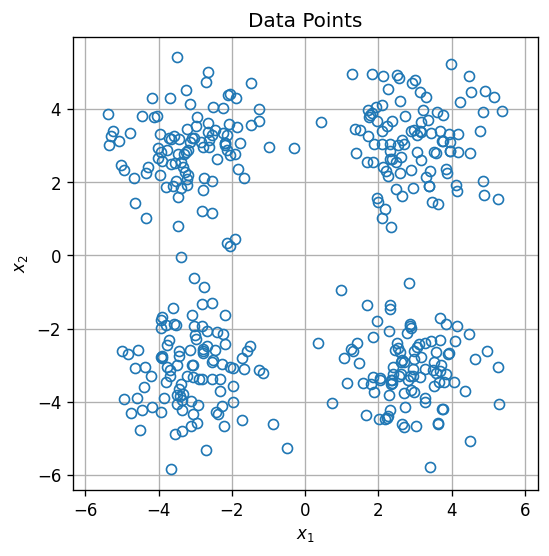

In [ ]:
## Prepare figure and plotting counters
fig, ax = plt.subplots(figsize=(5, 5))
raw_points = ax.plot(x[:, 0], x[:, 1], 'o', fillstyle='none')[0]
ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)
ax.axis('equal')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_title('Data Points')

fig.savefig('./output/gaussians_data.png', dpi=240)

In [ ]:
from scipy.spatial import distance  # A function for efficiently calculating all the distances between points in two lists of points.
from scipy.spatial import Voronoi, voronoi_plot_2d  # Functions for plotting the Voronoi cells

## Set K
k = 4

n_samples = len(x)

## Create a random generator using a fixed seed (we fix the seed for reproducible results)
rand_gen = np.random.RandomState(9)

## Initialize the means using k random points from the dataset
means = x[rand_gen.randint(low=0, high=n_samples, size=k)]
assignment = np.zeros(n_samples, dtype=int)

## Prepare figure
raw_points.remove()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:4]
clusters_points = [ax.plot([], [], 
                           'o',
                           fillstyle='none',
                           color=colors[i_cluster],
                           zorder=1,
                           )[0] for i_cluster in range(k)] 
centers_points = [ax.plot(means[i_cluster, 0], means[i_cluster, 1],
                          'o',
                          markersize=10,
                          color=colors[i_cluster],
                          mec='black',
                          zorder=2,
                          )[0] for i_cluster in range(k)]
arrows = [None] * 4

## Plot initial Voronoi cells
vor = Voronoi(np.concatenate([means, [[1e3, 1e3], [1e3, -1e3], [-1e3, 1e3], [-1e3, -1e3]]], axis=0))
voronoi_plot_2d(ax=ax, vor=vor, show_points=False, show_vertices=False, line_width=1, line_alpha=0.3)
ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)

i_step = 0
while True:
    i_step += 1
    assignment_old = assignment

    ## Step 1: Assign points to means
    distances = distance.cdist(x, means, 'euclidean')
    assignment = np.argmin(distances, axis=1)

    ## Stop criteria
    if (assignment == assignment_old).all():
        break

    ## Plot clusters
    ax.set_title('Step {} - Updating clusters'.format(i_step))
    for i_cluster in range(k):
        cluster_indices = assignment == i_cluster
        clusters_points[i_cluster].set_data(x[cluster_indices, 0], x[cluster_indices, 1])
        if arrows[i_cluster] is not None:
            arrows[i_cluster].remove()
            arrows[i_cluster] = None
    fig.canvas.draw()
    fig.savefig(f'./output/gaussians_step{i_step}a.png', dpi=240)
#     time.sleep(1)
    
    ## Step 2: Update means
    old_means = means.copy()  ## needed just for plotting
    for i_cluster in range(k):
        cluster_indices = assignment == i_cluster
        means[i_cluster] = x[cluster_indices].mean(axis=0)

    ## Plot means
    ax.set_title('Step {} - Updating centers'.format(i_step))
    for i_cluster in range(k):
        cluster_indices = assignment == i_cluster
        centers_points[i_cluster].set_data(means[i_cluster, 0], means[i_cluster, 1])
        if (old_means[i_cluster]  != means[i_cluster]).any():
            arrows[i_cluster] = ax.arrow(old_means[i_cluster, 0], old_means[i_cluster, 1],
                                         means[i_cluster, 0] - old_means[i_cluster, 0],
                                         means[i_cluster, 1] - old_means[i_cluster, 1],
                                         head_width=0.2,
                                         head_length=0.2,
                                         color='black',
                                         length_includes_head=True,
                                         zorder=3,
                                         )

    ## Update Voronoi cells on plot
    while(len(ax.collections)):
        ax.collections[-1].remove()
    vor = Voronoi(np.concatenate([means, [[1e3, 1e3], [1e3, -1e3], [-1e3, 1e3], [-1e3, -1e3]]], axis=0))
    voronoi_plot_2d(ax=ax, vor=vor, show_points=False, show_vertices=False, line_width=1, line_alpha=0.3)
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)
    fig.canvas.draw()
#     time.sleep(1)
    fig.savefig(f'./output/gaussians_step{i_step}b.png', dpi=240)

In [ ]:
## Save plot of clusters only
ax.set_title('Clustered data Points')
for i_cluster in range(k):
    if arrows[i_cluster] is not None:
        arrows[i_cluster].remove()
        arrows[i_cluster] = None
for point in centers_points:
    point.remove()
while(len(ax.collections)):
    ax.collections[-1].remove()
fig.canvas.draw()
fig.savefig('./output/gaussians_clusters.png', dpi=240)

## Results for different K's

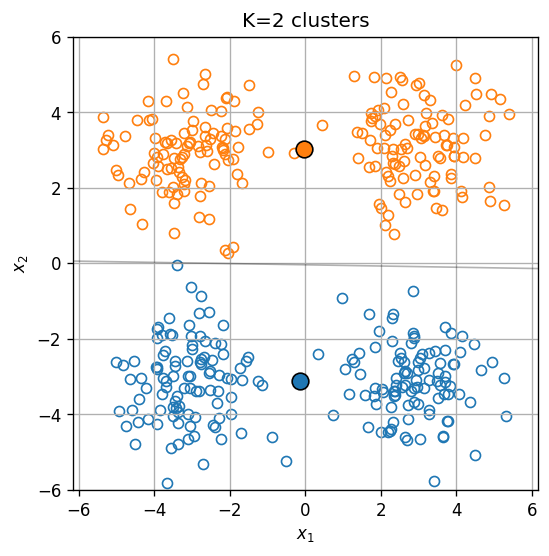

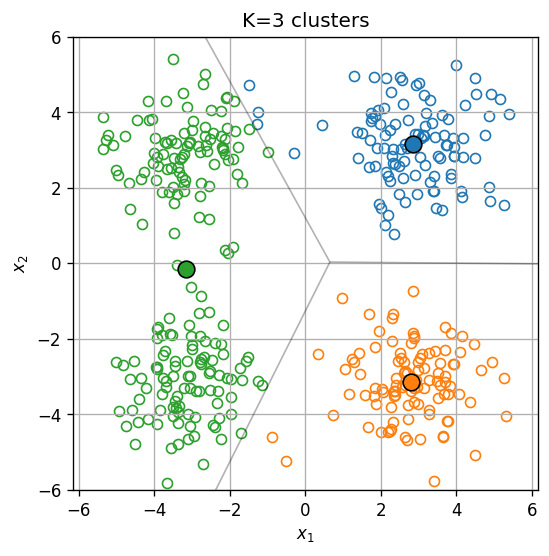

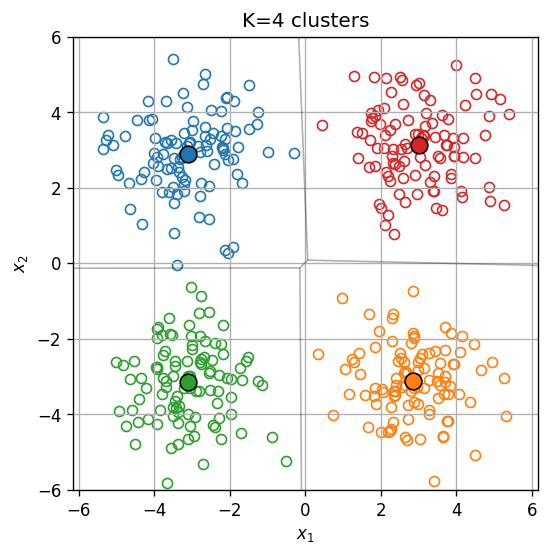

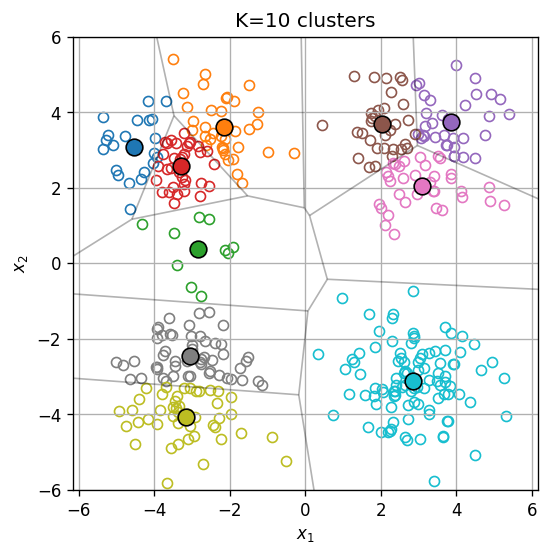

In [ ]:
rand_gen = np.random.RandomState(0)

for k in [2, 3, 4, 10]:
    ## Initialize the means using k random points from the dataset
    means = x[rand_gen.randint(low=0, high=n_samples, size=k)]
    assignment = np.zeros(n_samples, dtype=int)

    i_step = 0
    while True:
        i_step += 1
        assignment_old = assignment

        ## Step 1: Assign points to means
        distances = distance.cdist(x, means, 'euclidean')
        assignment = np.argmin(distances, axis=1)

        ## Stop criteria
        if (assignment == assignment_old).all():
            break

        ## Step 2: Update means
        old_means = means.copy()  ## needed just for plotting
        for i_cluster in range(k):
            cluster_indices = assignment == i_cluster
            means[i_cluster] = x[cluster_indices].mean(axis=0)

    ## Plot results
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.axis('equal')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_title('K={} clusters'.format(k))

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:k]
    for i_cluster in range(k):
        cluster_indices = assignment == i_cluster
        ax.plot(x[cluster_indices, 0], x[cluster_indices, 1],
            'o',
            fillstyle='none',
            color=colors[i_cluster],
            zorder=1,
            )
        ax.plot(means[i_cluster, 0], means[i_cluster, 1],
            'o',
            markersize=10,
            color=colors[i_cluster],
            mec='black',
            zorder=2,
            )

    vor = Voronoi(np.concatenate([means, [[1e3, 1e3], [1e3, -1e3], [-1e3, 1e3], [-1e3, -1e3]]], axis=0))
    voronoi_plot_2d(ax=ax, vor=vor, show_points=False, show_vertices=False, line_width=1, line_alpha=0.3)
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)
    fig.savefig(f'./output/gaussians_{k}_clusters.png', dpi=240)

In [ ]:
# rand_gen = np.random.RandomState(1)

# k_vec = np.arange(1, 400)
# err_vec = np.zeros(k_vec.shape)

# for i_k, k in enumerate(k_vec):
#     ## Initialize the means using k random points from the dataset
#     means = x[rand_gen.randint(low=0, high=n_samples, size=k)]
#     assignment = np.zeros(n_samples, dtype=int)

#     i_step = 0
#     while True:
#         i_step += 1
#         assignment_old = assignment

#         ## Step 1: Assign points to means
#         distances = distance.cdist(x, means, 'euclidean')
#         assignment = np.argmin(distances, axis=1)

#         ## Stop criteria
#         if (assignment == assignment_old).all():
#             break

#         ## Step 2: Update means
#         old_means = means.copy()  ## needed just for plotting
#         for i_cluster in range(k):
#             cluster_indices = assignment == i_cluster
#             if np.any(cluster_indices):
#                 means[i_cluster] = x[cluster_indices].mean(axis=0)
    
#     err_vec[i_k] = np.mean(((x - means[assignment]) ** 2).sum(axis=1)) ** 0.5

In [ ]:
# ## Plot
# fig, ax = plt.subplots(figsize=(5, 5))
# ax.set_xlabel('$K$')
# ax.set_ylabel('$E\\left(K\\right)$')
# ax.set_title('$E\\left(K\\right)$ vs. $K$')

# ax.plot(k_vec, err_vec)

# fig.savefig('../media/ek_vs_k.png'.format(k))

# ax.set_xlim(1, 9)
# ax.set_ylim(0, 7)

# fig.savefig('./output/ek_vs_k_zoom.png', dpi=240)

In [ ]:
# err_vec_rel = (err_vec[:-1] - err_vec[1:]) / err_vec[:-1]

# ## Plot
# fig, ax = plt.subplots(figsize=(5, 5))
# ax.set_title('$\\frac{-\\Delta E\\left(K\\right)}{E\\left(K\\right)}$ vs. $K$')
# ax.set_xlabel('$K$')
# ax.set_ylabel('$\\frac{-\\Delta E\\left(K\\right)}{E\\left(K\\right)}$')
# plt.tight_layout()

# ax.plot(k_vec[:-1], err_vec_rel)

# # fig.savefig('../media/ek_rel_vs_k.png'.format(k))

# ax.set_xlim(1, 9)
# ax.set_ylim(0, 0.7)

# fig.savefig('./output/ek_rel_vs_k_zoom.png', dpi=240)